In [765]:
import tensorflow as tf
import cirq
import numpy as np
import random
import sympy
from math import pi
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

In [681]:
def U_phi(q, W):
    for i in range(len(q)):
        rot = cirq.ZPowGate(exponent=W[i]/pi)
        yield rot(q[i])
    for i in range(len(q)-1):
        for j in range(i+1,len(q)):
            rot = cirq.ZPowGate(exponent=((pi-W[i])*(pi-W[j]))/pi)
            yield rot.on(q[j]).controlled_by(q[i])
            
def fancy_U(q, W):
    for i in range(len(q)):
        yield cirq.H(q[i])
    yield U_phi(q, W)
    for i in range(len(q)):
        yield cirq.H(q[i])
    yield U_phi(q, W)

def W_theta(q, theta):
    for i in range(len(q)):
        yield cirq.CZ.on(q[(i+1)%len(q)],q[i])
    for i in range(len(q)):
        rot = cirq.ZPowGate(exponent=theta[2*i]/pi)
        yield rot(q[i])
        rot = cirq.Ry(theta[2*i+1])
        yield rot(q[i])

def measure(q):
    for i in range(len(q)):
        yield cirq.measure(q[i], key=str(i))

In [725]:
def circuit(q, W, theta, layers):
    yield fancy_U(q,W)
    for i in range(len(q)):
        rot = cirq.ZPowGate(exponent = theta[2*i]/pi)
        yield rot(q[i])
        rot = cirq.Ry(theta[2*i + 1])
        yield rot(q[i])
    
    for i in range(1,layers+1):
        yield W_theta(q, theta[range(6*(i),6*(i+1))])
    yield measure(q)

In [739]:
def squared_loss(labels, predictions):
    loss =0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p)**2
    loss = loss/ len(labels)
    return loss

def J(theta, X, Y, nr_qubits, nr_layers, batch_i, shots, key):
    simulator = cirq.Simulator()
    for i in range(len(batch_i)):
        p_hold =0
        c = cirq.Circuit()
        c.append(circuit(qubits, X[batch_i[i]], theta, nr_layers))
        results = simulator.run(c, repetitions=shots)
        counter = (results.multi_measurement_histogram(keys="012"))
        for j in counter:
            if j.count(1) % 2 == 1:
                p_hold += counter[j]
        p[i] = p_hold/shots
    loss = squared_loss(Y[batch_i], p)
    return loss

In [758]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
	"""
	Call in a loop to create terminal progress bar
	@params:
		iteration   - Required  : current iteration (Int)
		total	   - Required  : total iterations (Int)
		prefix	  - Optional  : prefix string (Str)
		suffix	  - Optional  : suffix string (Str)
		decimals	- Optional  : positive number of decimals in percent complete (Int)
		length	  - Optional  : character length of bar (Int)
		fill		- Optional  : bar fill character (Str)
	"""
	percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
	filledLength = int(length * iteration // total)
	bar = fill * filledLength + '-' * (length - filledLength)
	print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
	# Print New Line on Complete
	if iteration == total: 
		print()

Progress: |██████████████████████████████████████████████████| 100.0% Complete
init_theta - end_theta: 
[ 0.355  0.073  0.114 -0.28   0.639  0.063 -0.1    0.146 -0.503  0.534
  0.111 -0.64 ]


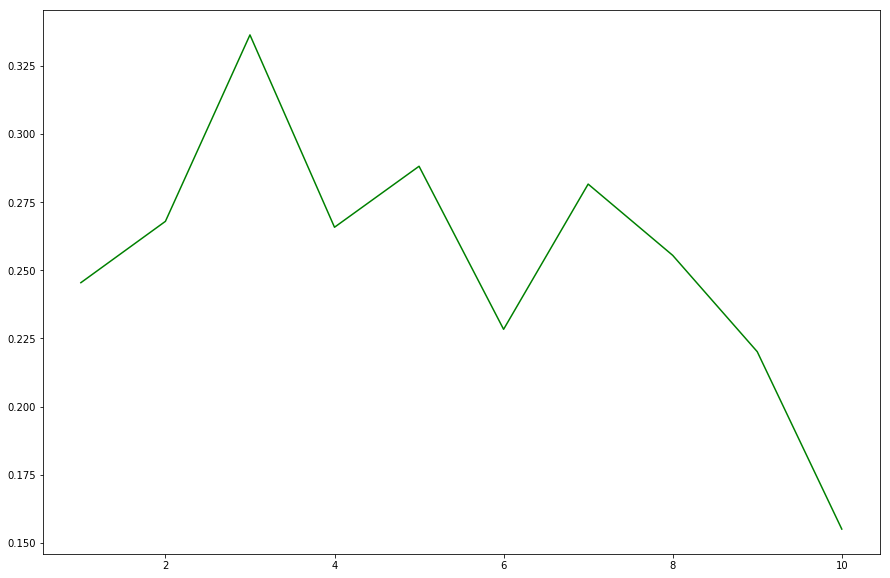

In [767]:
nr_qubits = 3
nr_layers = 1
batch_size = 10
shots = 100
iterations = 10
key = ""
for i in range(nr_qubits):
    key += str(i)

#Set up input and output qubits.
qubits = [cirq.GridQubit(i, 0) for i in range(nr_qubits)]

df = pd.read_csv("QA_data.csv")
X = df.iloc[:,:3].to_numpy()
Y = df.iloc[:,3].to_numpy()

nr_par = (nr_qubits*2)*(nr_layers+1)
init_theta = np.random.rand(nr_par,)*(2*pi)
theta = init_theta
eye = np.eye(nr_par)
c = 0.1
a = 2*pi*0.1
alpha = 0.602
gamma = 0.101
tot_loss = np.zeros(iterations)
for k in range(1,iterations+1):
    printProgressBar((k-1)*nr_par, iterations*nr_par, prefix = 'Progress:', suffix = 'Complete', length = 50)
    batch_ix = np.random.randint(0, len(X), (batch_size,))
    c_n = c/(k**(0.602))
    a_n = a/(k**(0.101))
    gradient = np.zeros(nr_par)
    
    for i in range(nr_par):
        printProgressBar((k-1)*nr_par+i, iterations*nr_par, prefix = 'Progress:', suffix = 'Complete', length = 50)
        start = time.time()
        loss_plus = J(theta+c_n*eye[:,i], X, Y, nr_qubits, nr_layers, batch_ix, shots, key)
        loss_minus= J(theta-c_n*eye[:,i], X, Y, nr_qubits, nr_layers, batch_ix, shots, key)
        gradient[i] = (loss_plus - loss_minus)/(2*c_n)
        end = time.time()
#     print(".")
#     print("loss: ",round(loss_plus,3)," time: ",round(end-start,3))
    tot_loss[k-1] = loss_plus
    theta = (theta - a_n*gradient) % (2*pi)
printProgressBar(iterations*nr_par, iterations*nr_par, prefix = 'Progress:', suffix = 'Complete', length = 50)

print("init_theta - end_theta: ")
print(np.around(init_theta-theta,3))

fig = plt.figure(figsize=(15,10))
ax = plt.gca()
plt.plot(range(1,iterations+1,1), tot_loss, 'g-', markersize=2)

In [460]:
# def rot_x_layer(length, half_turns):
#     """Yields X rotations by half_turns on a square grid of given length."""
#     rot1 = cirq.ZPowGate(exponent=half_turns)
#     rot2 = cirq.XPowGate(exponent=half_turns)
#     rot3 = cirq.ZPowGate(exponent=half_turns)
#     for i in range(length):
#         for j in range(length):
#             yield rot(cirq.GridQubit(i, j))

# circuit = cirq.Circuit()
# circuit.append(rot_x_layer(2, 0.1))
# print(circuit)

In [432]:
# def rand2d(rows, cols):
#     return [[random.choice([+1, -1]) for _ in range(cols)] for _ in range(rows)]

# def random_instance(length):
#     # transverse field terms
#     h = rand2d(length, length)
#     # links within a row
#     jr = rand2d(length - 1, length)
#     # links within a column
#     jc = rand2d(length, length - 1)
#     return (h, jr, jc)

# h, jr, jc = random_instance(3)
# print('transverse fields: {}'.format(h))
# print('row j fields: {}'.format(jr))
# print('column j fields: {}'.format(jc))

In [433]:
# def rot_z_layer(h, half_turns):
#     """Yields Z rotations by half_turns conditioned on the field h."""
#     gate = cirq.ZPowGate(exponent=half_turns)
#     for i, h_row in enumerate(h):
#         for j, h_ij in enumerate(h_row):
#             if h_ij == 1:
#                 yield gate(cirq.GridQubit(i, j))

# def rot_11_layer(jr, jc, half_turns):
#     """Yields rotations about |11> conditioned on the jr and jc fields."""
#     gate = cirq.CZPowGate(exponent=half_turns)    
#     for i, jr_row in enumerate(jr):
#         for j, jr_ij in enumerate(jr_row):
#             if jr_ij == -1:
#                 yield cirq.X(cirq.GridQubit(i, j))
#                 yield cirq.X(cirq.GridQubit(i + 1, j))
#             yield gate(cirq.GridQubit(i, j),
#                        cirq.GridQubit(i + 1, j))
#             if jr_ij == -1:
#                 yield cirq.X(cirq.GridQubit(i, j))
#                 yield cirq.X(cirq.GridQubit(i + 1, j))

#     for i, jc_row in enumerate(jc):
#         for j, jc_ij in enumerate(jc_row):
#             if jc_ij == -1:
#                 yield cirq.X(cirq.GridQubit(i, j))
#                 yield cirq.X(cirq.GridQubit(i, j + 1))
#             yield gate(cirq.GridQubit(i, j),
#                        cirq.GridQubit(i, j + 1))
#             if jc_ij == -1:
#                 yield cirq.X(cirq.GridQubit(i, j))
#                 yield cirq.X(cirq.GridQubit(i, j + 1))
                
# def one_step(h, jr, jc, x_half_turns, h_half_turns, j_half_turns):
#     length = len(h)
#     yield rot_x_layer(length, x_half_turns)
#     yield rot_z_layer(h, h_half_turns)
#     yield rot_11_layer(jr, jc, j_half_turns)

In [434]:
# h, jr, jc = random_instance(3)

# circuit = cirq.Circuit()    
# circuit.append(one_step(h, jr, jc, 0.1, 0.2, 0.3),
#                strategy=cirq.InsertStrategy.EARLIEST)
# print(circuit)

In [435]:
# simulator = cirq.Simulator()
# circuit = cirq.Circuit()    
# circuit.append(one_step(h, jr, jc, 0.1, 0.2, 0.3))
# circuit.append(cirq.measure(*qubits, key='x'))
# results = simulator.run(circuit, repetitions=100)
# print(results.histogram(key='x'))

In [436]:
# def energy_func(length, h, jr, jc):
#     def energy(measurements):
#         # Reshape measurement into array that matches grid shape.
#         meas_list_of_lists = [measurements[i * length:(i + 1) * length]
#                               for i in range(length)]
#         # Convert true/false to +1/-1.
#         pm_meas = 1 - 2 * np.array(meas_list_of_lists).astype(np.int32)

#         tot_energy = np.sum(pm_meas * h)
#         for i, jr_row in enumerate(jr):
#             for j, jr_ij in enumerate(jr_row):
#                 tot_energy += jr_ij * pm_meas[i, j] * pm_meas[i + 1, j]
#         for i, jc_row in enumerate(jc):
#             for j, jc_ij in enumerate(jc_row):
#                 tot_energy += jc_ij * pm_meas[i, j] * pm_meas[i, j + 1]
#         return tot_energy
#     return energy
# print(results.histogram(key='x', fold_func=energy_func(3, h, jr, jc)))

In [437]:
# def obj_func(result):
#     energy_hist = result.histogram(key='x', fold_func=energy_func(3, h, jr, jc))
#     return np.sum([k * v for k,v in energy_hist.items()]) / result.repetitions
# print('Value of the objective function {}'.format(obj_func(results)))

In [438]:
# circuit = cirq.Circuit()
# alpha = sympy.Symbol('alpha')
# beta = sympy.Symbol('beta')
# gamma = sympy.Symbol('gamma')
# circuit.append(one_step(h, jr, jc, alpha, beta, gamma))
# circuit.append(cirq.measure(*qubits, key='x'))
# print(circuit)

In [439]:
# resolver = cirq.ParamResolver({'alpha': 0.1, 'beta': 0.3, 'gamma': 0.7})
# resolved_circuit = cirq.resolve_parameters(circuit, resolver)

# sweep = (cirq.Linspace(key='alpha', start=0.1, stop=0.9, length=5)
#          * cirq.Linspace(key='beta', start=0.1, stop=0.9, length=5)
#          * cirq.Linspace(key='gamma', start=0.1, stop=0.9, length=5))
# results = simulator.run_sweep(circuit, params=sweep, repetitions=100)
# for result in results:
#     print(result.params.param_dict, obj_func(result))

In [440]:
# sweep_size = 10
# sweep = (cirq.Linspace(key='alpha', start=0.0, stop=1.0, length=10)
#          * cirq.Linspace(key='beta', start=0.0, stop=1.0, length=10)
#          * cirq.Linspace(key='gamma', start=0.0, stop=1.0, length=10))
# results = simulator.run_sweep(circuit, params=sweep, repetitions=100)

# min = None
# min_params = None
# for result in results:
#     value = obj_func(result)
#     if min is None or value < min:
#         min = value
#         min_params = result.params
# print('Minimum objective value is {}.'.format(min))